# Subset discontinuity tracking
This deck contains proofing of subset splitting methodologies

In [4]:
%load_ext autoreload

In [1]:
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


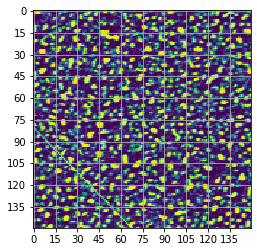

In [2]:
# preamble
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from crosspy import DIC, Imset
import os
import cv2

# folder path

folder_path=Path(r'/Users/alexanderbergsmo/Desktop/DIC/crosspy/data/Subset_tester')
Images = Imset(folder_path,'tif')

# Image crop

crop_on = False

if crop_on:
    img = Images.imload([0,1])
    y = 200
    h = 1000
    x = 600
    w = 1000
    Images = img[y:y+h, x:x+w, :]
else:
    Images = Images.imload([0,1])
   
fig = plt.figure()
ax = fig.gca()
ax.imshow(Images[:,:,1])
ax.set_xticks(np.arange(0, Images.shape[0], Images.shape[0]/10))
ax.set_yticks(np.arange(0, Images.shape[1], Images.shape[0]/10))
plt.grid()


Running sequential DIC on image pair 1 of 1 ...
... Completed in (s) 297.24266600608826


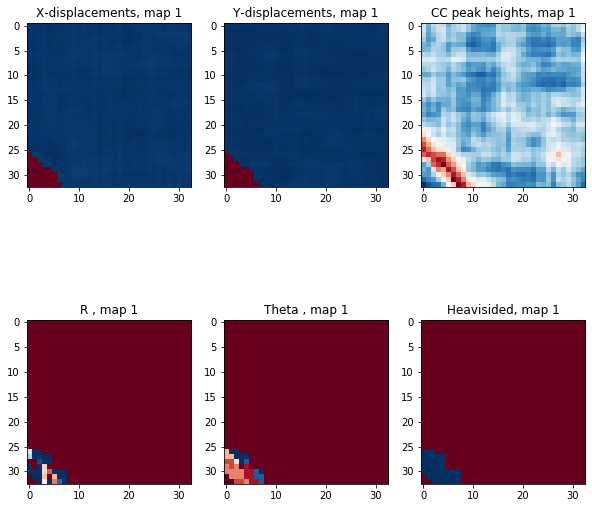


*** Profile printout saved to text file 'prun0'. 


In [9]:
%%prun -s cumulative -q -l 10 -T prun0
# Image crop

roi_1stpass = dict(size_pass = 50, overlap_percentage = 95, xcf_mesh=250)
filter_settings = [4,2,15,8]
# first pass

dic_1stpass = DIC(Images,roi_1stpass,filter_settings)
dic_1stpass.run_sequential(discontinuity=True)

dic_1stpass.plot_displacements()
#images_corrected = dic_1stpass.correct(method='polynomial',printing=1)

In [11]:
print(open('prun0', 'r').read())

22947064 function calls (22273866 primitive calls) in 299.326 seconds

   Ordered by: cumulative time
   List reduced from 1449 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  299.329  299.329 {built-in method builtins.exec}
        1    0.000    0.000  299.329  299.329 <string>:3(<module>)
        1    0.000    0.000  297.243  297.243 Classes.py:109(run_sequential)
        1    0.029    0.029  297.242  297.242 runDIC.py:94(run_DIC)
     1089    0.013    0.000  296.819    0.273 runDIC.py:13(subset_compare)
     1089    0.033    0.000  296.397    0.272 hs.py:306(minimise_rt_lstsq)
     1089    0.014    0.000  291.780    0.268 hs.py:301(least_squares_fit)
    43599    2.949    0.000  290.296    0.007 hs.py:131(hs_corr)
    44688    5.950    0.000  179.038    0.004 XCF.py:206(fxcorr)
    44688   58.019    0.001  156.505    0.004 XCF.py:99(freg)


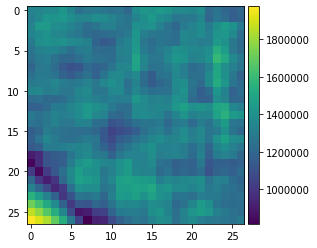

In [8]:
cc_peaks = dic_1stpass.ph_maps[:,:,0]
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

ax = plt.subplot(111)
im = ax.imshow(cc_peaks)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

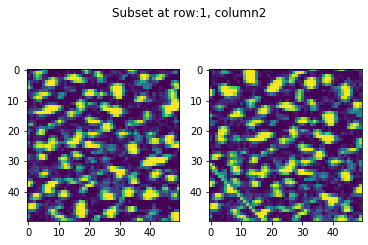

In [10]:
import cv2
filter_settings=[4,2,15,8]
ims = Images
#settings for heaviside pass
roi_disc = dict(size_pass = 50, overlap_percentage = 70, xcf_mesh=250)
dic_disc = DIC(ims, roi_disc,filter_settings)

# Function to plot selected subsets

def get_subsets(ims, row=3, col=1, roi_settings=None):
    if roi_settings==None:
        roi_settings = dict(
            size_pass = 100, 
            overlap_percentage = 70, 
            xcf_mesh=250)
    x0 = (col) * roi_settings['size_pass']
    x1 = x0 + roi_settings['size_pass']
    y0 = (row) * roi_settings['size_pass']
    y1 = y0 + roi_settings['size_pass']
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Subset at row:{}, column{}'.format(row,col))
    images = []
    for i in range(0,ims.shape[2]):
        images.append(axs[i].imshow(ims[x0:x1, y0:y1, i]))
        
    subsets = ims[x0:x1, y0:y1, :]
    return subsets


    
# Select a subset, here at row 20, column 20

#subsets = get_subsets(ims,5, 0, roi_disc) # has slip
subsets = get_subsets(ims,1, 2, roi_disc) # has no slip


In [11]:
from numba import double, jit
from numba import int32, float32, uint8, jitclass
import numpy as np

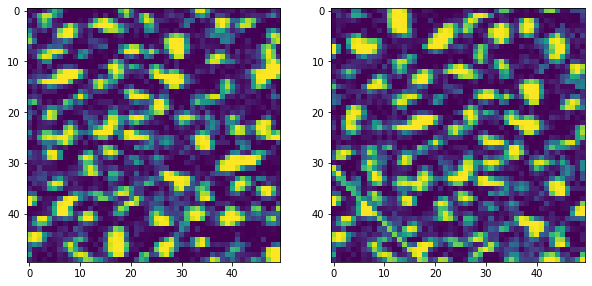

In [12]:


# Apply a line and step function

spec = [
    ('x', float32),
    ('y', float32)
]

@jitclass(spec)
class Point: 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y 

@jit(nopython=True)
def line_test(pixel, r, theta, subsets):
    # function to test if a pixel lies above or below a line segment
    # Find start and end points of line segments for different cases of theta and r
    dx = subsets.shape[0]
    # Line segment to interogation point
    p1 = Point(0, 0)
    q1 = Point(pixel[0], pixel[1])
    
    # Vector magnitude cases
    #theta = np.degrees(theta)
    theta = theta % 360
    if r == 0:
        r = 1e-8
        
    # Rotation cases
    if theta == 0. or theta == 360.: # vertical to right
        x1 = r
        x2 = q1.x
        if x2 > x1:
            return False
        else:
            return True
    elif theta == 90.: # horizontal line above
        y1 = r
        y2 = q1.y
        if y2>y1:
            return False
        else:
            return True
    elif theta == 180.: # vertical to left
        x1 = -r
        x2 = q1.x
        if x2 > x1:
            return True
        else:
            return False
    elif theta == 270.: # horizontal below
        y1 = -r
        y2 = q1.y
        if y2 < y1:
            return False
        else:
            return True
    elif theta>0 and theta<180:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        y1 = q1.y
        y2 = m*q1.x + c
        if y1>y2:
            return False
        else:
            return True
    elif theta>180 and theta<360:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        
        y1 = q1.y
        y2 = m*q1.x + c
        if y1<y2:
            return False
        else:
            return True
@jit(uint8[:,:,:](uint8[:,:,:], float32, float32)) 
def subset_hsfilter(subsets, r, theta):
    # preallocate arrays
    hsfilter = np.zeros((subsets.shape[0],subsets.shape[0]))
    xc = hsfilter.shape[0]/2
    yc = hsfilter.shape[1]/2
    xc = int(xc)
    yc = int(yc)
    
    # Create x and y coordinates which are centred
    xs,ys = np.meshgrid(range(-xc, xc), range(-yc,yc))
    
    # iterate pixel by pixel
    for col in range(subsets.shape[0]):
        for row in range(subsets.shape[0]):
            #rasters through columns and rows for a given coordinate in xy
            x = xs[row,col]
            y = ys[row,col]
            # Note that y axis is mirrored
            pixel = [x, (-1*y)]
            # Test if pixel is beyond the discontinuity line
            flag  =line_test(pixel, r, theta, subsets)
            if flag:
                hsfilter[row,col] = True
            else:
                hsfilter[row,col] = False
                
    hs_subset = np.zeros(subsets.shape)
    hs_subset[:,:,0] = np.multiply(hsfilter,subsets[:,:,0])
    hs_subset[:,:,1] = np.multiply(hsfilter,subsets[:,:,1])
    return hs_subset



result = subset_hsfilter(subsets,r=50.333101, theta=227.3058124)

f, axarr = plt.subplots(1,2, figsize=(10,5))
axarr[0].imshow(result[:,:,0])
axarr[1].imshow(result[:,:,1])


Testing various correlation functions below

# FREG hs corr:

---> FXCORR is already the fastests and most accurate function available --> alternatively rewrite as a lightweight correlation function without subpixel registration

In [15]:
from crosspy import XCF

def hs_corr(x, subsets, d, prepared_ffts):
    # unpack vector
    r, theta = x
    # apply heaviside filter
    filtered_subsets = subset_hsfilter(subsets, r, theta)
    
    # assign to clean variables for legibility
    a = filtered_subsets[:,:,0]
    b = filtered_subsets[:,:,1]
    
    # cross correlate using freg - this is still faster than silly numpy correlate
    result = XCF.fxcorr(a, b, d, prepared_ffts)
    
    # normalise via division by active pixels
    act_px = np.count_nonzero(a != False)
    result = np.asarray(result)
    result[2] = result[2]/act_px
    
    # return vectorised result containign dx,dy,cc
    return result

prepared_ffts = XCF.plan_ffts(dic_disc)
tester = hs_corr([16,70], subsets, dic_disc, prepared_ffts)

print(tester)


[9.9920000e+00 8.9320000e+00 1.0833029e+07]


In [50]:
from skopt import Optimizer

from matplotlib.colors import Normalize
prepared_ffts = XCF.plan_ffts(dic_disc)
def hsin(x,subsets,d,prepared_ffts):
    dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
    return dx,dy,c

#@jit
def map_hscorr(n,ia,d,prepared_ffts):
    
    #preallocate:
   
    # r and theta range
    
    rs = np.linspace(0,ia.shape[2]/2,n)
    theta = np.linspace(0,360,n*3)
    theta = np.radians(theta)
    z = np.zeros((len(rs),len(theta),3))
    # meshgrid is not compilable
    for i, r in enumerate(rs):
        for j, th in enumerate(theta):
            dx,dy,dz = hsin([r,th],ia,d,prepared_ffts)
            z[i,j,0] = dx
            z[i,j,1] = dy
            z[i,j,2] = dz
    return z


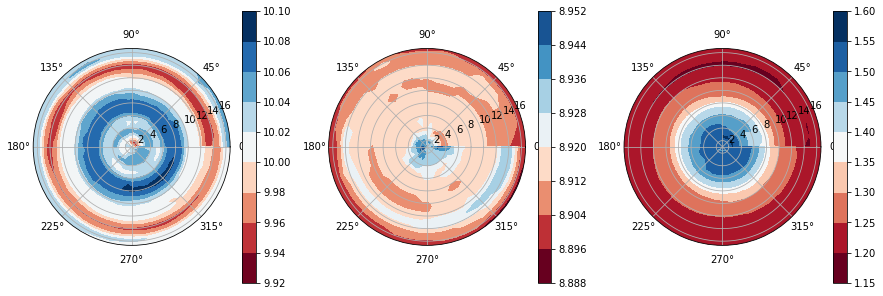

In [21]:
# Plotting as polar figure
import numpy as np
import matplotlib.pyplot as plt

#gen data
n= 5

#subsets = ia
a = subsets[:,:,0]
b = subsets[:,:,1]
dx0, dy0, cc0 = XCF.fxcorr(a, b, dic_disc, prepared_ffts)
cc0 = cc0/(a.shape[0]**2)
thetas = np.radians(np.linspace(0, 360, 50))
#theta_rad = np.radians(np.linspace(0, 360, 20))
rs = np.linspace(0, a.shape[0]/3, 20)
r, theta = np.meshgrid(rs, thetas)
vals = np.c_[r.ravel(),theta.ravel()]
fx = np.reshape([hsin(val,subsets,dic_disc,prepared_ffts) for val in vals],(len(theta),len(rs),3))

fx[:,:,2] = np.abs(fx[:,:,2]/cc0)

#plot
fig, ax = plt.subplots(1, 3, subplot_kw={'projection' :'polar'}, figsize=(15, 5))
for i in range(3): 
    aax = ax[i]
    aax.set_rlim(1, rs.max())
    z = fx[:,:,i]
    cmap = aax.contourf(theta, r, z,vmin=z.min(), vmax=z.max(), cmap='RdBu')
    fig.colorbar(cmap,ax=aax)



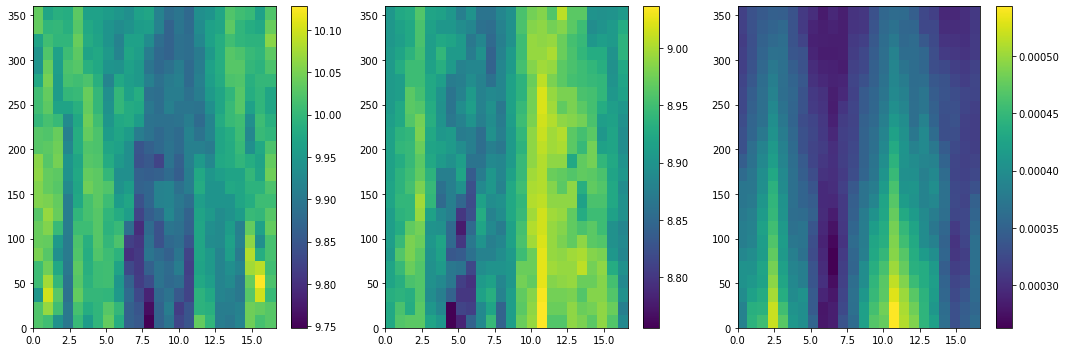

In [22]:
# Plotting as colormesh

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
n = 25
rs = np.linspace(0,subsets.shape[0]/3, n)
ths = np.linspace(0,360,n)
x,y = np.meshgrid(rs,ths)
z = np.zeros((x.shape[0],x.shape[1],3))
for i,r in enumerate(rs):
    for j,theta in enumerate(ths):
        z[i,j,:]=hs_corr([r,theta],subsets,dic_disc,prepared_ffts)

z[i,j,2] = z[i,j,2]
for i in range(3):
    ax = axs[i]
    fx = z[:,:,i]
    im = ax.pcolormesh(x,y,fx)
    fig.colorbar(im,ax=ax)

fig.tight_layout()

# Plotting in 3d

[16.66666667] [240.]


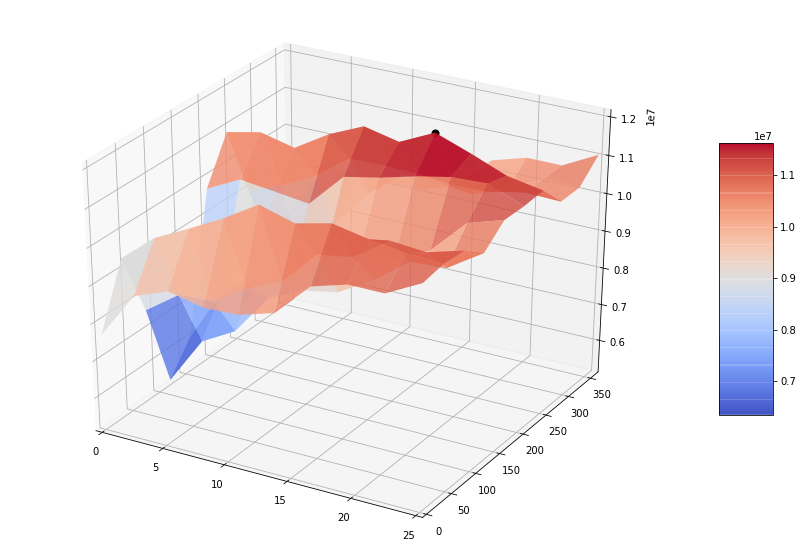

In [16]:
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

def hsin(x,subsets,d,prepared_ffts):
    dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
    return dx,dy,c

n = 10
rs = np.linspace(0,np.sqrt((subsets.shape[0]/2)**2), n)
ths = np.linspace(0,360,n)
x, y = np.meshgrid(rs,ths)

vals = np.c_[np.ravel(x),np.ravel(y)]

fx = np.array([hsin(val, subsets, dic_disc, prepared_ffts) for val in vals]).reshape(n,n,3)

fig = plt.figure(figsize=(15,10))



ax = fig.gca(projection='3d')
z = fx[:,:,2]
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha =0.8)#, linewidth=0, antialiased=False)
ax.set_xlim(rs.min(), rs.max())
ax.set_ylim(ths.min(), ths.max())
ax.set_zlim(z.min(), z.max())
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


# add a point indicating peak location
loc = np.where(z.max() == z)

xmx =x[loc]
ymx =y[loc]
zmx =z[loc]
ax.scatter(xs=xmx,ys=ymx,zs=zmx,s=50,c='k')
print(xmx,ymx)
plt.show()

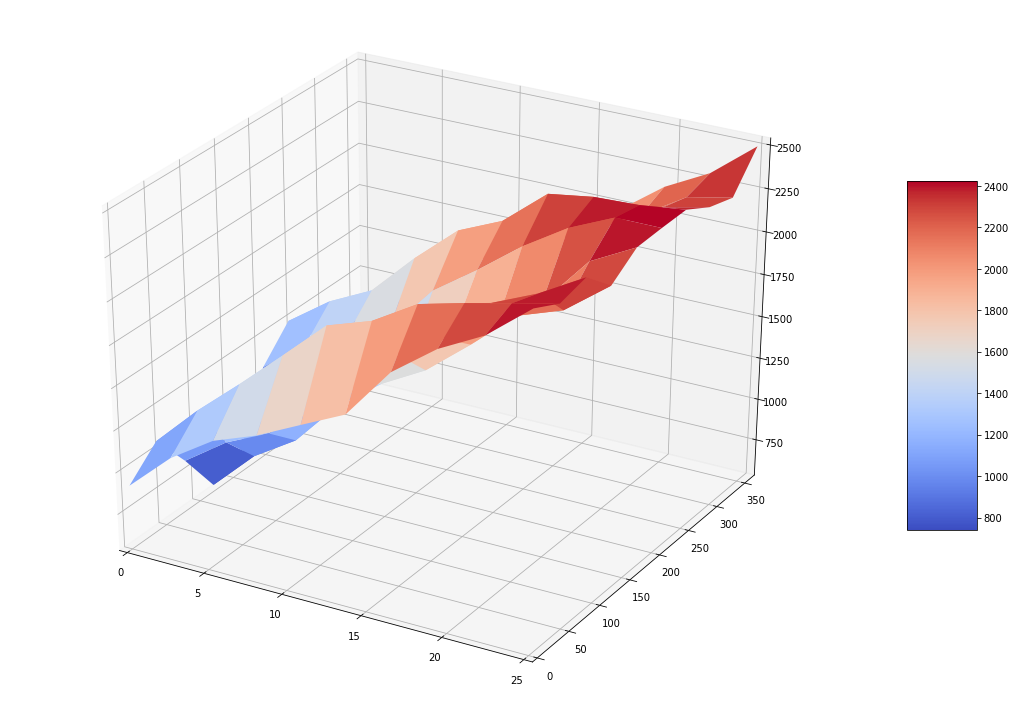

In [58]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
dx1, dy1, cc_org = XCF.fxcorr(subsets[:,:,0], subsets[:,:,1], dic_disc, prepared_ffts)
z = (fx[:,:,2])/(cc_org/subsets.shape[0]**2)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm)#, linewidth=0, antialiased=False)
ax.set_xlim(rs.min(), rs.max())
ax.set_ylim(ths.min(), ths.max())
ax.set_zlim(z.min(), z.max())
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

# Bayesian optimization for noisy, expensive, black box functions - no gradient descent needed - > GOOD FOR FIRST ORDER APPROXIMATION

In [25]:
from functools import partial
from skopt import gp_minimize, forest_minimize, dummy_minimize
def hsin(x,subsets,d,prepared_ffts):
    _,_,c=hs_corr(x,subsets,d,prepared_ffts)
    return -1.*c
@jit
def opt_rt(subsets, n_calls, d, prepared_ffts):
    # Initial naked search
    a = subsets[:,:,0]
    b = subsets[:,:,1]
    dx1, dy1, cc1 = XCF.fxcorr(a, b, d, prepared_ffts)
    # local function
    
    # define search boundary
    bounds = [(0., subsets.shape[0]/3), (0., 360.0)]
    func = partial(hsin, subsets=subsets,d=d, prepared_ffts=prepared_ffts)
    # Use a Bayesian-gauss optimisation to approximate minimum
    res = gp_minimize(func,                  # the function to minimize
                  bounds,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=n_calls,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=1e-8,       # the noise level (optional)
                  random_state=1234)   # the random seed
    x = res.x
    r = np.around(x[0],2)
    theta = np.around(x[1],2)
    dx0, dy0, cc0 = hs_corr(x, subsets, d, prepared_ffts)
    # Accept the approximation only if the peak height is 
    # significantly higher than the naked cross correlation
    cc1 = cc1/(subsets.shape[0]**2)
    if np.abs(cc0/cc1) >= 1.0 and r != 0.0:     
        return dx0, dy0, cc0, r, theta, True
    else:
        return dx1, dy1, cc1, False, False, False


    
def minimize_rt(subsets,d,prepared_ffts):
    dx, dy, cc, r, theta, hson = opt_rt(subsets,20, d, prepared_ffts)
    #print("r = {}, theta = {}".format(r,theta))
    return dx,dy,cc,r,theta,hson

dx, dy, cc, r, theta, hson = minimize_rt(subsets,dic_disc, prepared_ffts)

print(r,theta)


0.71 47.27


In [51]:
# Least squares

def hsin(x,subsets,d,prepared_ffts):
    _,_,c=hs_corr(x,subsets,d,prepared_ffts)
    return c

def A_mat(x,y=0,n=2):
    # Function to generate A matrices for polynomial solutions of Ax = b
    if n == 2:
        A = np.zeros((len(x),6))
        A[:,0]=np.squeeze(x**2)
        A[:,1]=np.squeeze(x)
        A[:,2]=np.squeeze(y**2)
        A[:,3]=np.squeeze(y)
        A[:,4]=np.squeeze(x*y)
        A[:,5]=np.ones(len(x))
        return A
    elif n == 3:
        A = np.zeros((len(x),10))
        A[:,0]=np.squeeze(x**3)
        A[:,1]=np.squeeze((x**2)*y)
        A[:,2]=np.squeeze(x*(y**2))
        A[:,3]=np.squeeze(y**3)
        A[:,4]=np.squeeze(x**2)
        A[:,5]=np.squeeze(x*y)
        A[:,6]=np.squeeze(y**2)
        A[:,7]=np.squeeze(x)
        A[:,8]=np.squeeze(y)
        A[:,9]=np.ones(len(x))
        return A
    elif n == 4:
        A = np.zeros((len(x),15))
        A[:,0]=np.squeeze(x**4)
        A[:,1]=np.squeeze(y**4)
        A[:,2]=np.squeeze((x**3)*y)
        A[:,3]=np.squeeze((x**2) * (y**2))
        A[:,4]=np.squeeze(x*(y**3))
        A[:,5]=np.squeeze(x**3)
        A[:,6]=np.squeeze(y**3)
        A[:,7]=np.squeeze((x**2)*y)
        A[:,8]=np.squeeze(x*(y**2))
        A[:,9]=np.squeeze(x**2)
        A[:,10]=np.squeeze(y**2)
        A[:,11]=np.squeeze(x*y)
        A[:,12]=np.squeeze(x)
        A[:,13]=np.squeeze(y)
        A[:,14]=np.ones(len(x))
        return A




In [27]:
def least_squares_xcf(n, resolution, subsets, d, prepared_ffts):
    min_angle = 0
    max_angle = 180
    # generate mesh spaces
    r_max = subsets.shape[0]/2
    r = np.linspace(1, r_max,resolution)
    theta = np.linspace(min_angle, max_angle, resolution)

    x_measured, y_measured = np.meshgrid(r, theta)

    # unravel to 1d
    r = x_measured.ravel()
    theta = y_measured.ravel()

    # generate trial Ax=b based on measured response
    atr = A_mat(r, theta, n)
    vals = np.c_[r,theta]

    # here we measure XCF
    btr = np.array([hsin(val, subsets, d, prepared_ffts) for val in vals])
    fx_measured = btr.reshape(resolution, resolution)
    # x params
    x, _, _, _ = np.linalg.lstsq(atr,btr)


    # populate modelling space
    n_mod = 1000
    r = np.linspace(1, r_max, n_mod)
    theta = np.linspace(min_angle, max_angle, n_mod)
    x_mod,y_mod = np.meshgrid(r, theta)

    # unravel to 1d
    r = x_mod#.ravel()
    theta = y_mod#.ravel()

    # obtain modelling solution

    if n == 2:
        fx = x[0]*r**2 + x[1]*r + x[2]*theta**2 + x[3]*theta + x[4]*theta*r + x[5]
    elif n == 3:
        fx = (x[0]*r**3 + x[1]*(r**2)*theta + x[2]*r*(theta**2) 
            + x[3]*theta**3 + x[4]*r**2 + x[5]*r*theta + x[6]*theta**2 
            + x[7]*r + x[8]*theta + x[9])
    elif n == 4:
        fx = (x[0]*r**4 + x[1]*theta**4 + x[2]*(r**3)*theta
            + x[3]*(r**2)*(theta**2) + x[4]*r*(theta**3) + x[5]*r**3
            + x[6]*theta**3 + x[7]*(r**2)*theta + x[8]*r*(theta**2)
            + x[9]*r**2 + x[10]*theta**2 + x[11]*r*theta + x[12]*r
            + x[13]*theta + x[14])

    # find maximum
    loc = np.where(fx.max() == fx)
    rsol = r[loc]
    thetasol = theta[loc]

    return rsol, thetasol

rsol, thetasol = least_squares_xcf(4, 10, subsets, dic_disc, prepared_ffts)

print(rsol,thetasol)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

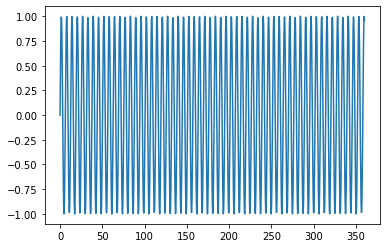

[227.36842105]


In [68]:
# simple function to search angle space
from scipy import optimize
def peak_angle(resolution, subsets, d, prepared_ffts):

    def hsin(x,subsets,d,prepared_ffts):
        dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
        return c
    theta = np.linspace(0, 360, resolution)
    r = np.full(len(theta), subsets.shape[0]/4)

    def A_mat(x):
        A = np.zeros((len(x),6))
        A[:,0]=np.squeeze(x**2)
        A[:,1]=np.squeeze(x)
        A[:,2]=np.ones(len(x))
        return A
    # generate trial Ax=b based on measured response
    atr = A_mat(theta)
    vals = np.c_[r,theta]

    # here we measure XCF
    btr = np.array([hsin(val, subsets, d, prepared_ffts) for val in vals])
    fx_measured = btr
    # x params

    x, _, _, _ = np.linalg.lstsq(atr, btr)

    # model
    theta_mod = np.linspace(0, 360, 1000)

    fx_mod = x[0]*theta_mod**2 + x[1] * theta_mod + x[2]


    def test_func(x, a, b):
        return a * np.sin(b * x)

    params, params_covariance = optimize.curve_fit(test_func, theta, fx_measured)

    fx_s = test_func(theta_mod, params[0], params[1])                                    
    # plot for the sake of it

    fig, ax = plt.subplots()

    ax.plot(theta_mod, fx_s)

    plt.show()

    fx_measured.max()

    loc = np.where(fx_measured.max() == fx_measured)
    theta_sol = theta[loc]
    
    if len(theta_sol) > 1:
        theta_sol = 0

    return theta_sol

thetasol = peak_angle(20, subsets, dic_disc, prepared_ffts)

print(thetasol)

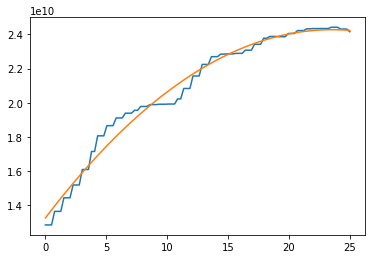

NameError: name 'r_mod' is not defined

In [63]:

def peak_r(theta, resolution, subsets, d, prepared_ffts):

    def hsin(x,subsets,d,prepared_ffts):
        _,_,c=hs_corr(x,subsets,d,prepared_ffts)
        return c
    # angle space
    theta = np.full((resolution),theta)

    # create search space in r
    r_max = subsets.shape[0]/2
    r = np.linspace(0,subsets.shape[0]/2,resolution)

    c = np.column_stack((r,theta))

    # search
    fx = np.array([hsin(val,subsets, d, prepared_ffts) for val in c])

    # create model

    def A_mat(x):
        A = np.zeros((len(x),6))
        A[:,0]=np.squeeze(x**2)
        A[:,1]=np.squeeze(x)
        A[:,2]=np.ones(len(x))
        return A

    # Ax = b

    A = A_mat(c[:,0])
    x, _, _, _ = np.linalg.lstsq(A,fx)
  
    # model

    r_m = np.linspace(0,r_max,1000)
    fx_m = x[0]*r_m**2 + x[1]*r_m + x[2]

    # plot for fun

    fig, ax = plt.subplots()

    ax.plot(r,fx, r_m, fx_m)

    plt.show()

    # find peak

    loc = np.where(fx_m.max() == fx_m)
    r_sol = r_mod[loc]

    return r_sol, np.mean(fx_m), np.max(fx_m) 

rsol = peak_r(225, 100, subsets, dic_disc, prepared_ffts)




In [ ]:
def least_squares_fit(res, subsets, d,prepared_ffts):
    theta = peak_angle(res, subsets, d, prepared_ffts)
    r, xcf_mean, xcf_peak = peak_r(theta, res, subsets, d, prepared_ffts)
    return r, theta, xcf_mean, xcf_peak

def minimise_rt_lstsq(subsets, d, prepared_ffts):

    def hsin(x,subsets,d,prepared_ffts):
        dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
        return c

    r, theta, xcf_mean, xcf_peak = least_squares_fit(20, subsets, dic_disc, prepared_ffts)

    dx, dy, cc = XCF.fxcorr(subsets[:,:,0], subsets[:,:,1], d, prepared_ffts)
    cc = cc/(subsets.shape[0]**2)
    if xcf_peak > cc:
        x = np.array([float(r), float(theta)])
        dx,dy,cc = hsin(x, subsets, d, prepared_ffts)
        return dx,dy,cc,r,theta,True
    else:
        return dx,dy,cc,False,False,False


%timeit (minimise_rt_lstsq(subsets, dic_disc, prepared_ffts))

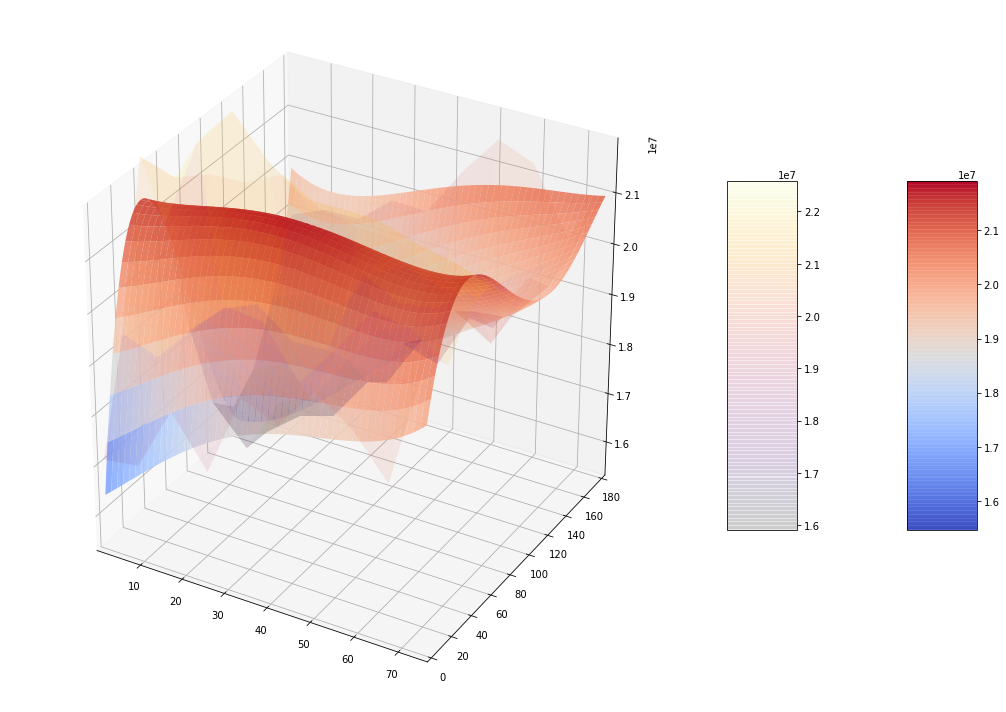

In [193]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')


surf = ax.plot_surface(x_mod, y_mod, fx, cmap=cm.coolwarm, alpha=0.9,linewidth=1.0)#, linewidth=0, antialiased=False)
surf_measured = ax.plot_surface(x_measured, y_measured, fx_measured,cmap=cm.inferno, linewidth=0.5,alpha=0.1)
ax.set_xlim(x_mod.min(), x_mod.max())
ax.set_ylim(y_mod.min(), y_mod.max())
ax.set_zlim(fx.min(), fx.max())
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.colorbar(surf_measured, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

#Finepass

In [402]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import functools
import pyfftw
from crosspy.XCF import *
from crosspy.ImagePreparation import *
import numexpr as ne
# preallocate

roi_disc = dict(size_pass = 30, overlap_percentage = 90, xcf_mesh=250)
dic_disc = DIC(ims, roi_disc,filter_settings)
def subset_compare(d,imnos,subset_n,prepared_ffts,discontinuity=False):
    #grab the reference and test subsets, and get subpixel registration
    ref=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[0])
    test=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[1])
    #get the displacements 
    if discontinuity == True:
        subsets = np.stack((ref,test),axis=2)
        #r,theta=opt_rt(subsets, n_calls=10, d=d, prepared_ffts=prepared_ffts)
        #dxs,dys,phs = hs_corr([r,theta],subsets,d=d,prepared_ffts=prepared_ffts)
        #dxs, dys, phs,r,theta, hson = minimize_rt(subsets,d,prepared_ffts)
        dxs, dys, phs,r,theta, hson = minimise_rt_lstsq(subsets,d, prepared_ffts)
        return dxs,dys,phs,r,theta,hson
    else:
        dxs,dys,phs=fxcorr(ref,test,d,prepared_ffts)
        return dxs,dys,phs,None, None, None


def run_DIC(d,imnos=[0,1],discontinuity=False, cores=None,ffttype='fftw_numpy'):
    #fft type can be : fftw_numpy (default), fftw_scipy, else defaults to numpy

    #set up numexpr to run with the chosen number of threads
    
    #discontinuity enables or disables slip trace tracking via heaviside filtering
    if cores==None:
        cores=multiprocessing.cpu_count()

    ne.set_num_threads(cores)


    #preallocate for this DIC pair
    phs=np.zeros(d.n_subsets)
    dxs=np.zeros(d.n_subsets)
    dys=np.zeros(d.n_subsets)

    prepared_ffts=plan_ffts(d,ffttype)

    #decide the number of cores to allocate
    if cores:
        pyfftw.config.NUM_THREADS = cores
    else:
        pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()

    #enable the pyfftw cache for speedup
    pyfftw.interfaces.cache.enable()   
    
    #check for discontinuity tracker
    if discontinuity == True:
        r = np.zeros(d.n_subsets)
        theta = np.zeros(d.n_subsets)
        hson = np.zeros(d.n_subsets)
        for subset_n in range(0,d.n_subsets):
            dxs[subset_n],dys[subset_n],phs[subset_n],r[subset_n],theta[subset_n],hson[subset_n]=subset_compare(d,imnos,subset_n,prepared_ffts,discontinuity=True)
        dx_map=np.reshape(dxs,(d.n_rows,d.n_cols),'F')
        dy_map=np.reshape(dys,(d.n_rows,d.n_cols),'F')
        ph_map=np.reshape(phs,(d.n_rows,d.n_cols),'F')
        r_map = np.reshape(r,(d.n_rows,d.n_cols),'F')
        theta_map = np.reshape(theta,(d.n_rows,d.n_cols),'F')
        hson_map = np.reshape(hson,(d.n_rows,d.n_cols),'F')
        return dx_map, dy_map, ph_map, r_map, theta_map, hson_map
    else:
        for subset_n in range(0,d.n_subsets):
            dxs[subset_n],dys[subset_n],phs[subset_n]=subset_compare(d,imnos,subset_n,prepared_ffts)

        #translate best_dxs etc back onto image grid
        dx_map=np.reshape(dxs,(d.n_rows,d.n_cols),'F')
        dy_map=np.reshape(dys,(d.n_rows,d.n_cols),'F')
        ph_map=np.reshape(phs,(d.n_rows,d.n_cols),'F')

        return dx_map,dy_map,ph_map

dx_map, dy_map, ph_map, r_map, theta_map, hson_map = run_DIC(dic_disc, discontinuity=True)

(40, 40)


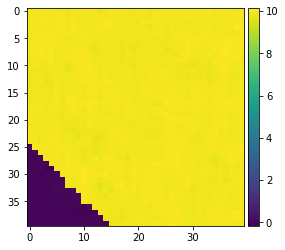

In [409]:
print(dx_map.shape)
ax = plt.subplot(111)
im = ax.imshow(dx_map)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


In [11]:
roi_disc = dict(size_pass = 40, overlap_percentage = 90, xcf_mesh=250)
dic_disc = DIC(ims, roi_disc,filter_settings)

dic_disc.run_sequential(cores=4, discontinuity=True)

Running sequential DIC on image pair 1 of 1 ...


NameError: name 'dic_disc' is not defined

In [ ]:
def plot_4(d, num, cmap):

    fig, axs = plt.subplots(2, 2, figsize=(20,20))
    fig.suptitle('Strain maps '+str(num))
    Nr = 2
    Nc = 2
    images = []
    data = [d.strain_11[:,:,num], d.strain_22[:,:,num], d.strain_12[:,:,num], d.strain_eff[:,:,num]]
    names = ["11", "22", "12", "effective"]
    no = 0
    for i in range(Nr):
        for j in range(Nc):
            vmin = np.mean(data[no].flatten()) - 1*np.std(data[no].flatten())
            vmax = np.mean(data[no].flatten()) + 1*np.std(data[no].flatten())
            images.append(axs[i, j].imshow(data[no], cmap=cmap, vmin=0, vmax=0.3))
            axs[i, j].set_title(names[no])
            axs[i, j].label_outer()
            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            fig.colorbar(images[no], ax=axs[i,j], shrink=0.6)
            no += 1
    plt.show()
    
    
    return fig, axs

fig, axs = plot_4(dic_2ndpass, 0, 'RdBu')

fig.savefig('STRAINS_'+str(roi_2ndpass['size_pass'])+'_'+str(roi_2ndpass['overlap_percentage']), dpi=400)